<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/ner_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import Model, Input, layers, Sequential
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split

In [2]:
url = 'https://raw.githubusercontent.com/BeiqiZh/Named-Entity-Recognition/main/datasets/ner_dataset.csv'
df = pd.read_csv(url, encoding='latin1')

In [3]:
df = df.fillna(method = 'ffill')
df.head(3)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O


In [4]:
sentences = df.groupby(['Sentence #'])['Word'].apply(list)
POSs = df.groupby(['Sentence #'])['POS'].apply(list)
TAGs = df.groupby(['Sentence #'])['Tag'].apply(list)

In [5]:
sentences_total = [' '.join(i) for i in sentences]

In [6]:
seq_len = int(np.max([len(i) for i  in sentences]))
print(seq_len)
tf_vectorizer = tf.keras.layers.TextVectorization(
                        output_sequence_length = seq_len,
                        max_tokens = 35000
                        )

104


In [7]:
tf_vectorizer.adapt(sentences_total)

In [8]:
corpus_size = len(tf_vectorizer.get_vocabulary())
print('CORPUS_SIZE :',corpus_size)

CORPUS_SIZE : 31309


In [9]:
sentences_total[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [10]:
sequences = tf_vectorizer(sentences_total)

In [11]:
len(df)

1048575

In [12]:
unique_tags = df['Tag'].unique()

In [13]:
unique_tags

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [14]:
tag_2enc = {j:i+1 for i,j in enumerate(unique_tags)}
enc_2tag = {i+1:j for i,j in enumerate(unique_tags)}

In [15]:
enc_2tag

{1: 'O',
 2: 'B-geo',
 3: 'B-gpe',
 4: 'B-per',
 5: 'I-geo',
 6: 'B-org',
 7: 'I-org',
 8: 'B-tim',
 9: 'B-art',
 10: 'I-art',
 11: 'I-per',
 12: 'I-gpe',
 13: 'I-tim',
 14: 'B-nat',
 15: 'B-eve',
 16: 'I-eve',
 17: 'I-nat'}

In [16]:
df['Tag_enc'] = df['Tag'].map(tag_2enc)
TAGs_enc = df.groupby(['Sentence #'])['Tag_enc'].apply(list)

In [17]:
TAGs_enc = [list(i) for i in TAGs_enc]

In [18]:
print(seq_len)
len(tag_2enc)
TAGs_enc
pad_seq = tf.keras.utils.pad_sequences(
    TAGs_enc,
    maxlen=seq_len,
    dtype='int32',
    padding='post',
    # truncating='pre',
    value=0.0
)


104


In [19]:
np.array(sequences)

array([[ 247,    4,  965, ...,    0,    0,    0],
       [ 318,   33,   26, ...,    0,    0,    0],
       [1146, 4506,   91, ...,    0,    0,    0],
       ...,
       [ 259,   76,    8, ...,    0,    0,    0],
       [  70,  510,   88, ...,    0,    0,    0],
       [   2,   49,  108, ...,    0,    0,    0]])

In [20]:
train_sequences, test_sequences, train_pad_seq, test_pad_seq = train_test_split(np.array(sequences),pad_seq, train_size = 0.8, test_size = 0.1, random_state = 42)

In [21]:
print(train_sequences.shape)
print(test_sequences.shape)
print(train_pad_seq.shape)

(38367, 104)
(4796, 104)
(38367, 104)


In [22]:
embed_dim = 64
input_layer = Input(shape=(seq_len,))
emb_layer = Embedding(corpus_size, embed_dim, name = 'embedding_layer')(input_layer)
# flat_layer = Flatten(name = 'Flatten_layer')(emb_layer)
d1 = Dense(64, activation = 'relu')(emb_layer)
d2 = Dense(32, activation = 'relu')(d1)
final = Dense(len(tag_2enc)+1, activation = 'softmax')(d2)

model1 = Model(inputs = [input_layer], outputs = [final])

model1.compile(
    loss = 'SparseCategoricalCrossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy'])
model1.fit(train_sequences,
           train_pad_seq,
           epochs = 3,
           batch_size =50)

Epoch 1/3
768/768 [==============================] - 34s 43ms/step - loss: 0.3480 - accuracy: 0.9508
Epoch 2/3
768/768 [==============================] - 35s 46ms/step - loss: 0.1752 - accuracy: 0.9600
Epoch 3/3
768/768 [==============================] - 34s 44ms/step - loss: 0.1711 - accuracy: 0.9609


In [23]:
# tags_enc_np = [np.array(i) for i in TAGs_enc]

In [24]:
predictions = model1.predict([test_sequences])

150/150 [==============================] - 2s 9ms/step


In [35]:
test_pad_seq.shape

(4796, 104)

In [26]:
predictions.shape

(4796, 104, 18)

In [27]:
len(predictions)

4796

In [30]:
var2 = []
for i in range(predictions.shape[0]):
    var1 = []
    for j in range(predictions.shape[1]):
        var1.append(np.argmax(predictions[i][j]))
    var2.append(var1)

In [34]:
np.array(var2).shape

(4796, 104)

In [40]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [39]:
conf_mat = confusion_matrix(np.concatenate(test_pad_seq), np.concatenate(np.array(var2)))

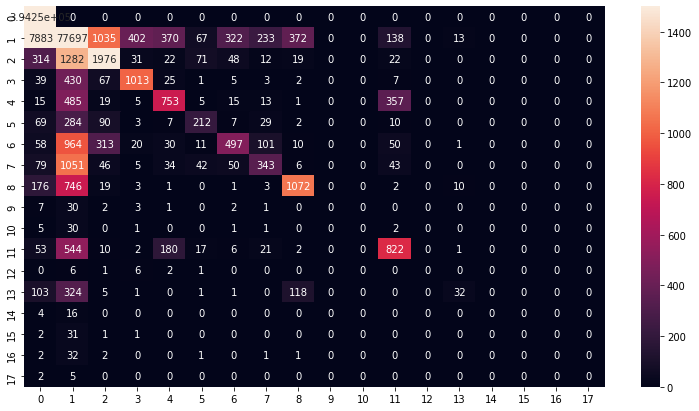

In [41]:



fig, ax = plt.subplots(figsize=(13,7)) 
# labels=['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
sns.heatmap(conf_mat, annot=True,fmt='.5g',vmin=0, vmax=1500,
                            # xticklabels=labels, yticklabels=labels
            );
     
